# Bitcoin historical data EDA and Predictions using LSTM

### Importing Libraries and Data

In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# Define the ticker symbol for Bitcoin
tickerSymbol = 'BTC-USD'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
btc_data = tickerData.history(period='1d', start='2020-01-01', end='2023-01-01')

### Data Information

In [3]:
# Display the first few rows of the dataframe
btc_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-01 00:00:00+00:00,7194.892090,7254.330566,7174.944336,7200.174316,18565664997,0.0,0.0
2020-01-02 00:00:00+00:00,7202.551270,7212.155273,6935.270020,6985.470215,20802083465,0.0,0.0
2020-01-03 00:00:00+00:00,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,0.0,0.0
2020-01-04 00:00:00+00:00,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,0.0,0.0
2020-01-05 00:00:00+00:00,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,0.0,0.0


In [4]:
# Convert the index to column
btc_data = btc_data.reset_index()

btc_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-01-01 00:00:00+00:00,7194.892090,7254.330566,7174.944336,7200.174316,18565664997,0.0,0.0
1,2020-01-02 00:00:00+00:00,7202.551270,7212.155273,6935.270020,6985.470215,20802083465,0.0,0.0
2,2020-01-03 00:00:00+00:00,6984.428711,7413.715332,6914.996094,7344.884277,28111481032,0.0,0.0
3,2020-01-04 00:00:00+00:00,7345.375488,7427.385742,7309.514160,7410.656738,18444271275,0.0,0.0
4,2020-01-05 00:00:00+00:00,7410.451660,7544.497070,7400.535645,7411.317383,19725074095,0.0,0.0


In [5]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          1096 non-null   datetime64[ns, UTC]
 1   Open          1096 non-null   float64            
 2   High          1096 non-null   float64            
 3   Low           1096 non-null   float64            
 4   Close         1096 non-null   float64            
 5   Volume        1096 non-null   int64              
 6   Dividends     1096 non-null   float64            
 7   Stock Splits  1096 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 68.6 KB


### Data Cleaning

In [6]:
btc_data = btc_data.dropna()

### Descriptive Statistics

In [7]:
# Calculate descriptive statistics for the cleaned dataset
descriptive_statistics = btc_data.describe()

descriptive_statistics

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1096.000000,1096.000000,1096.000000,1096.000000,1.096000e+03,1096.0,1096.0
mean,28896.239315,29611.669111,28088.818300,28900.779941,3.672738e+10,0.0,0.0
std,17131.558446,17586.114641,16593.964977,17117.490259,1.891026e+10,0.0,0.0
min,5002.578125,5331.833984,4106.980957,4970.788086,9.744636e+09,0.0,0.0
25%,11663.331299,11798.418701,11438.752686,11679.550049,2.537217e+10,0.0,0.0
50%,23692.820312,24162.116211,23078.830078,23696.078125,3.300065e+10,0.0,0.0
75%,42961.791016,43907.089844,41992.264648,42897.068359,4.325613e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


### Time Series Analysis

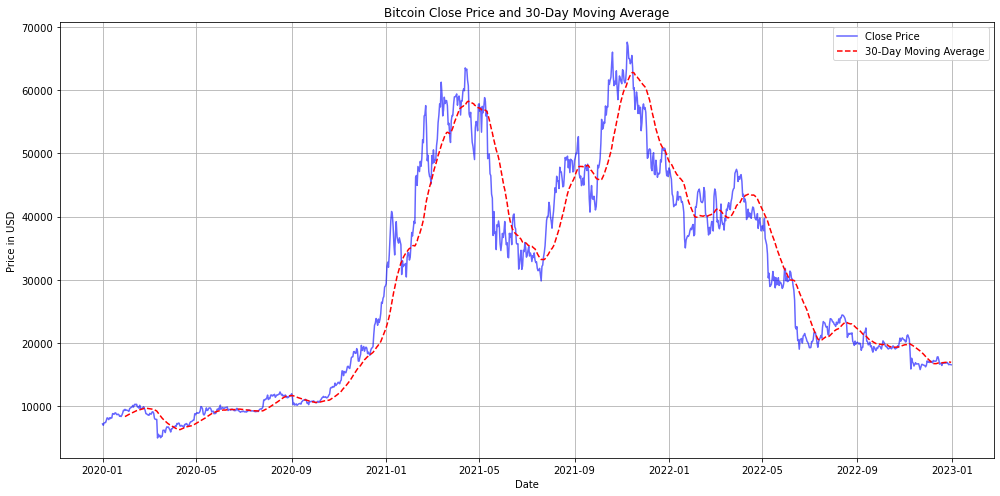

In [8]:
# Convert the 'Date' column to datetime type for better plotting
btc_data['Date'] = pd.to_datetime(btc_data['Date'])

# Calculate a 30-day moving average for the 'Close' prices
btc_data['30-Day MA'] = btc_data['Close'].rolling(window=30).mean()

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(btc_data['Date'], btc_data['Close'], label='Close Price', color='blue', alpha=0.6)
plt.plot(btc_data['Date'], btc_data['30-Day MA'], label='30-Day Moving Average', color='red', linestyle='--')
plt.title('Bitcoin Close Price and 30-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Price in USD')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

The chart shows Bitcoin's daily closing price in blue, depicting its volatility and trading price on each day from early 2020 to the beginning of 2023, along with its 30-day moving average in red, which smooths out short-term fluctuations to highlight longer-term trends. The moving average's lag behind the closing price reflects its nature as an average of the past month's prices. The chart's peaks and troughs illustrate periods of high volatility, while converging lines suggest more stability.

### Volatility Analysis

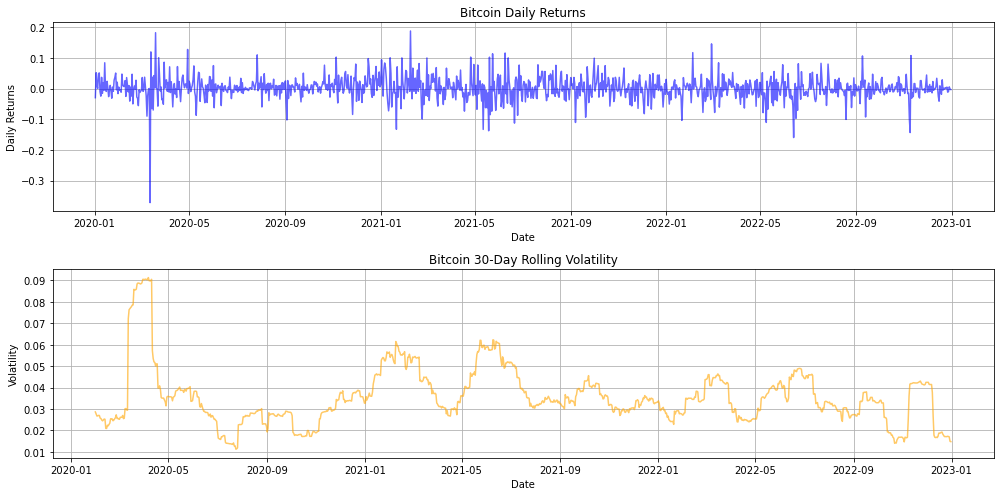

In [9]:
# Calculate the daily returns
btc_data['Daily Returns'] = btc_data['Close'].pct_change()

# Calculate the volatility (standard deviation of daily returns)
overall_volatility = btc_data['Daily Returns'].std()

# Calculate a rolling 30-day volatility (standard deviation of daily returns over a 30-day window)
btc_data['30-Day Volatility'] = btc_data['Daily Returns'].rolling(window=30).std()

# Plotting the daily returns and 30-day rolling volatility
plt.figure(figsize=(14, 7))

# Plot daily returns
plt.subplot(2, 1, 1)
plt.plot(btc_data['Date'], btc_data['Daily Returns'], label='Daily Returns', color='blue', alpha=0.6)
plt.title('Bitcoin Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.grid(True)

# Plot 30-day rolling volatility
plt.subplot(2, 1, 2)
plt.plot(btc_data['Date'], btc_data['30-Day Volatility'], label='30-Day Volatility', color='orange', alpha=0.6)
plt.title('Bitcoin 30-Day Rolling Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.grid(True)

plt.tight_layout()
plt.show()

The provided charts offer insights into Bitcoin’s daily returns and rolling volatility from early 2020 to the beginning of 2023. The top chart, illustrating daily returns, shows the percentage change in Bitcoin's price each day, with substantial fluctuations indicating the asset's high short-term volatility. The bottom chart tracks Bitcoin's 30-day rolling volatility, which measures how much Bitcoin's returns deviate from their mean over the past month; it highlights periods of relative stability as well as spikes in volatility. Notably, the volatility trend decreases over time, suggesting a potential stabilization in the Bitcoin market as it matures, despite the ongoing presence of short-term price swings.

In [20]:
overall_volatility_pct = overall_volatility*100

overall_volatility_pct = round(overall_volatility_pct, 2)

print("Overall Volatility: " + str(overall_volatility_pct) + "%")

Overall Volatility: 3.79%


A volatility of 3.79% implies that the price of the asset, in this case, Bitcoin, experiences average fluctuations of 3.79% from its mean price over a specified period. This is a measure of the dispersion of returns and is often used to gauge the risk or uncertainty in the price of an asset.

## Predictive Modeling using LSTM

### Normalizing the Data

In [11]:
# Normalize the Data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(btc_data['Close'].values.reshape(-1, 1))

### Creating Sequences

In [12]:
# Create Sequences
def create_sequences(data, sequence_length):
    xs, ys = [], []
    for i in range(len(data) - sequence_length - 1):
        x = data[i:(i + sequence_length), 0]
        y = data[i + sequence_length, 0]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 60  # Using the past 60 days to predict the next dayon
X, y = create_sequences(scaled_close, sequence_length)

### Splitting the Data

In [13]:
# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### The LSTM Model

In [14]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

### Training the Model

In [15]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,  # Number of epochs can be adjusted
    batch_size=32,  # Batch size can be adjusted
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
26/26 [==============================] - 6s 59ms/step - loss: 0.0498 - val_loss: 0.0044
Epoch 2/50
26/26 [==============================] - 1s 30ms/step - loss: 0.0047 - val_loss: 0.0014
Epoch 3/50
26/26 [==============================] - 1s 28ms/step - loss: 0.0030 - val_loss: 0.0013
Epoch 4/50
26/26 [==============================] - 1s 33ms/step - loss: 0.0029 - val_loss: 9.3188e-04
Epoch 5/50
26/26 [==============================] - 1s 36ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 6/50
26/26 [==============================] - 1s 36ms/step - loss: 0.0025 - val_loss: 8.6913e-04
Epoch 7/50
26/26 [==============================] - 1s 34ms/step - loss: 0.0024 - val_loss: 8.6963e-04
Epoch 8/50
26/26 [==============================] - 1s 36ms/step - loss: 0.0023 - val_loss: 6.6588e-04
Epoch 9/50
26/26 [==============================] - 1s 35ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/50
26/26 [==============================] - 1s 35ms/step - loss: 0.0021 - val_loss: 

### Evaluate the Model

7/7 [==============================] - 0s 12ms/step - loss: 5.5421e-04


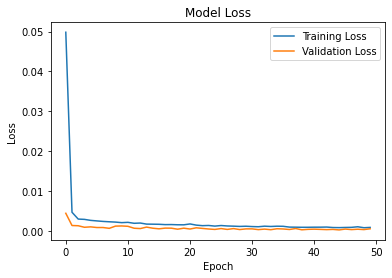

In [16]:
# Evaluate the model
test_loss = model.evaluate(X_test, y_test)

# Plot training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

- The training loss (in blue) and validation loss (in orange) are very close to each other and both decrease to a low level. This is a good sign, indicating that the model is fitting the data well without overfitting, as overfitting would be indicated by a low training loss but a high validation loss.
- The low and stable validation loss also suggests that the model generalizes well to unseen data, which is essential for creating a robust model that performs consistently.
- The final loss value mentioned above the chart, 5.5421e-04, is quite low, suggesting that the model has a good level of accuracy in its predictions.

### Making Predictions

7/7 [==============================] - 0s 15ms/step


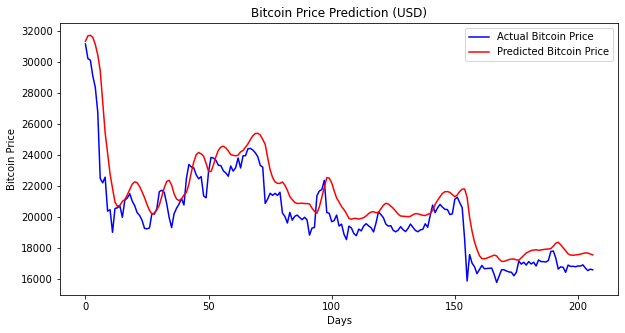

In [21]:
# Predictions
predicted_prices = model.predict(X_test)

# Invert the scaling for predicted prices
predicted_prices = scaler.inverse_transform(predicted_prices)
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the actual vs. predicted prices
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(actual_prices, color='blue', label='Actual Bitcoin Price')
plt.plot(predicted_prices, color='red', label='Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction (USD)')
plt.xlabel('Days')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()

- The model appears to closely follow the actual price trends of Bitcoin, indicating it has learned well from the historical data it was trained on.
The predicted line mirrors the actual price line quite well, suggesting the model's effectiveness in capturing the patterns within the time series data it was provided.
- There are points where the predicted price diverges from the actual price, which is expected since exact predictions are extremely difficult due to the volatile nature of cryptocurrency prices.
- It's notable that the prediction seems to slightly lag behind the actual price. This lag is common in time series forecasting because models often take a bit of time to 'catch up' with sudden changes in trends.

### Calculating additional performance metrics

In [18]:
# Calculate additional performance metrics
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)

In [19]:
# Creating a DataFrame to display the metrics in a tabular format
metrics_data = { "Metrics": ["Test Loss", "Mean Absolute Error (MAE)", "Mean Squared Error (MSE)", "Root Mean Squared Error (RMSE)", "R²"],
                "Values": [test_loss, mae, mse, rmse, r2]}

metrics_df = pd.DataFrame(metrics_data)
metrics_df

,Metrics,Values
0,Test Loss,5.542124e-04
1,Mean Absolute Error (MAE),1.150157e+03
2,Mean Squared Error (MSE),2.171551e+06
3,Root Mean Squared Error (RMSE),1.473618e+03
4,R²,7.054777e-01


- Test Loss (5.54212e-04): This is a very low value, suggesting that the model has a good fit to the test data. The specific type of loss (e.g., mean squared error) is not specified, but the magnitude indicates strong performance.

- Mean Absolute Error (MAE) (1.150157e+03): An MAE of approximately 1,150 means that, on average, the model's predictions are about 1,150 units (likely USD) away from the actual Bitcoin prices. Whether this is good or bad depends on the scale of Bitcoin price movements during the testing period.

- Mean Squared Error (MSE) (2.171551e+06): An MSE of around 2,171,551 suggests that there have been some substantial errors in the predictions. Because it's sensitive to outliers, a few large errors can increase MSE significantly.

- Root Mean Squared Error (RMSE) (1.473618e+03): An RMSE of approximately 1,473 implies that the model's predictions are, on average, 1,473 units (again, likely USD) from the actual values. In the context of Bitcoin's price, this could be considered a relatively large error given Bitcoin's price volatility.

- R-squared (R²) (0.7054777 or 70.55%): An R² of 70.55% is quite high, indicating that the model explains a substantial portion of the variance in the Bitcoin prices.